# <center> Eddy Overturning StreamFunctions </center> 

***
** Eddy Overturning Scripts **

* Implicit
* Explicit
* Diabatic/Adiabatic 

***

# 1. Implicit

In [7]:
# Some parameters
VAR = 'Psi'  # Pick what plot
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots
Year = 'TAV.nc'
Qplot = 'Y'

In [69]:
# Load in Modules
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
#import glob
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import numpy.ma as ma
%matplotlib inline

if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ']

# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'


# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/'+Year
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)
# Set Parameters
alpha = 2.000000E-04
g = -9.81
rho_0 = 1000
C_p = 3985
gridfilepath = x+'/3daynokpp/'
file2 = netCDF4.Dataset(gridfilepath+'grid.nc', 'r')
Zp = file2.variables['Zp1'][:]
Z = file2.variables['Z'][:]
Y = file2.variables['Yp1'][:]
Yc = file2.variables['Y'][:]
Zmatrix = np.zeros((len(Z), len(Y)))
Zmatrix[:, :] = 1
dx = Y[1]-Y[0]  # Find Resolution
dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
dzc = Z[0:len(Z)-1]-Z[1:len(Z)]
Zmatrix = np.apply_along_axis(np.multiply,0,Zmatrix,dz)
ny = len(Y)
nz = len(Z)
f0 = -1.000000E-04
beta = 1.000000E-11

In [9]:
# Surface Heat Fluxes
Ly = 2000e3
Lx = 1000e3
nx = np.round(Lx/dx)
ny = np.round(Ly/dx)
Q_0 = 10
Q = np.zeros_like(Yc)
pi = math.pi
Q=np.zeros(np.shape(Q))
Q[0:int(5*ny/36)] = Q_0*(np.cos(Yc[0:int(5*ny/36)]*(pi/(Yc[int(10*ny/36)]))))
Q[int(5*ny/36):int(20*ny/36)] = -Q_0*(np.sin((Yc[int(5*ny/36):int(20*ny/36)]-Yc[int(5*ny/36)])*(pi/(Yc[int(15*ny/36)]))))
Q[int(20*ny/36):int(30*ny/36)] = Q_0*(np.sin(Yc[0:int(10*ny/36)]*(pi/(Yc[int(10*ny/36)]))))

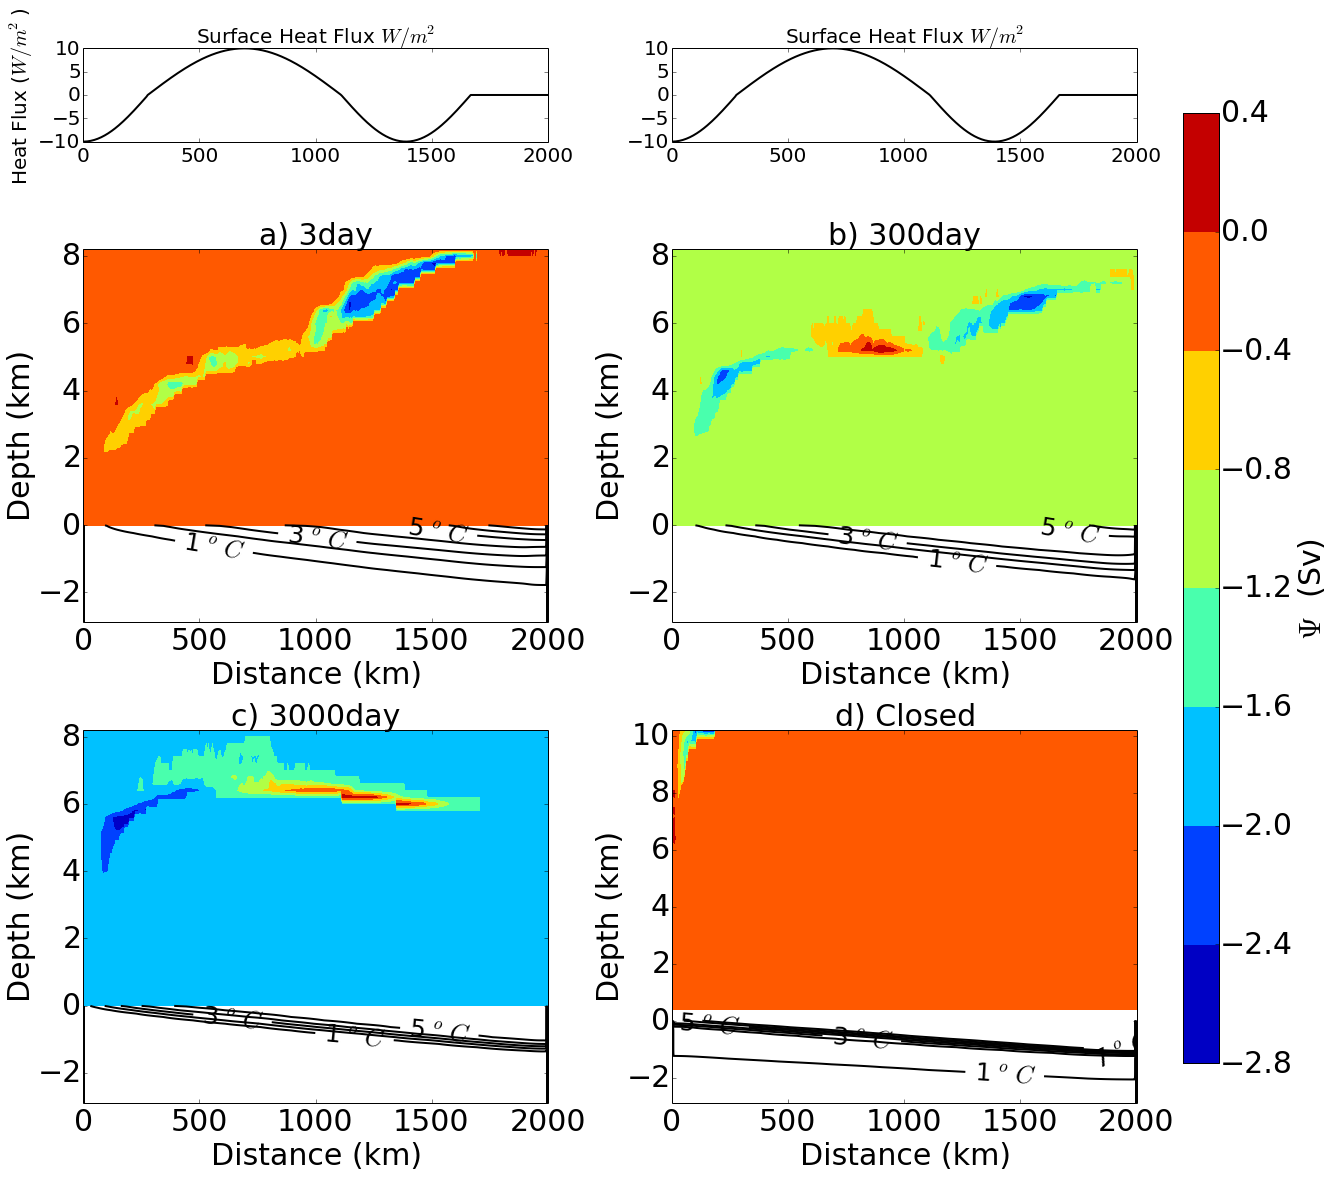

In [111]:
fig = plt.figure(figsize=(16.5, 16.5))
# Plot Heat Flux on top
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
# Create Panels
Psi_levs = np.arange(-2., .5, .21)
Psi_ticks =np.arange(-1., 1., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    Va = file2read.variables["LaVa1TH"][:].mean(axis=3).mean(axis=0)
    P = file2read.variables["LaPs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = numba_regridy(VTfdz)
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    psiz = get_psi_iso_z(psi, th[0:-1,:],Z)
    Paz =  get_psi_iso_z(P, th[:,:],Z)
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    Tlayers = Rho[1:-1]
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(Va),Tlayers)
    depths =np.cumsum(th,axis=0)-2985
    SP = ddy_cgrid_centered(depths,Yc)
    Vaz =  get_psi_iso_z(Va*Rho_matrix, th[:,:],Z)

 
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    # Mean Overturning for Eddy Streamfuction
    V = file2.variables['VVEL'][:]
    W = file2.variables['WVEL'][:].mean(axis=0)
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi_m = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi_m = np.cumsum(-psi_m[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi_m = np.pad(psi_m, pad_width=npad, mode='constant', constant_values=0)
    # Eddy
    Psied = psiz - numba_regridz(psi_m)/10**6
    # Mean Stream Function:
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(fname, 'r')
    TTav = file2.variables['THETA'][:].mean(axis=0).mean(axis=2)
    VTav = file2.variables['VVEL'][:].mean(axis=0).mean(axis=2)
    WTav = file2.variables['WVEL'][:].mean(axis=0).mean(axis=2)
    npad =((0,1),(0,0))
    WTav = np.pad(WTav,pad_width=npad, mode='constant', constant_values=0)
    ax = fig.add_subplot(2, 2, i+1)
    Eddy1 = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV_VT.nc'
    f2 = netCDF4.Dataset(Eddy1,'r')
    VTTav = f2.variables['VVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = f2.variables['WVELTH'][:].mean(axis=0).mean(axis=2)
    WTTav = np.pad(WTTav,pad_width=npad, mode='constant', constant_values=0)
    VpTp = numba_regridy(VTTav) - numba_regridy(VTav)*TTav
    WpTp = numba_regridz(WTTav) - numba_regridz(WTav)*TTav
    # PLOT PANNELS
    # EddyHeatFlux =  numba_regridy(Vaz[:,:])-numba_regridy(Vtave.mean(axis=2))*Tavlat,Yc)
    # EddyHeatFlux[-15::] = 0
    Va[P>0.98]=0
    if Full != 'Y' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full != 'Y' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,8,1))
    p = ax.contourf(Y/1000, Tlayers,
               Va*Rho_matrix, cmap=plt.cm.jet)
    q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, )
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

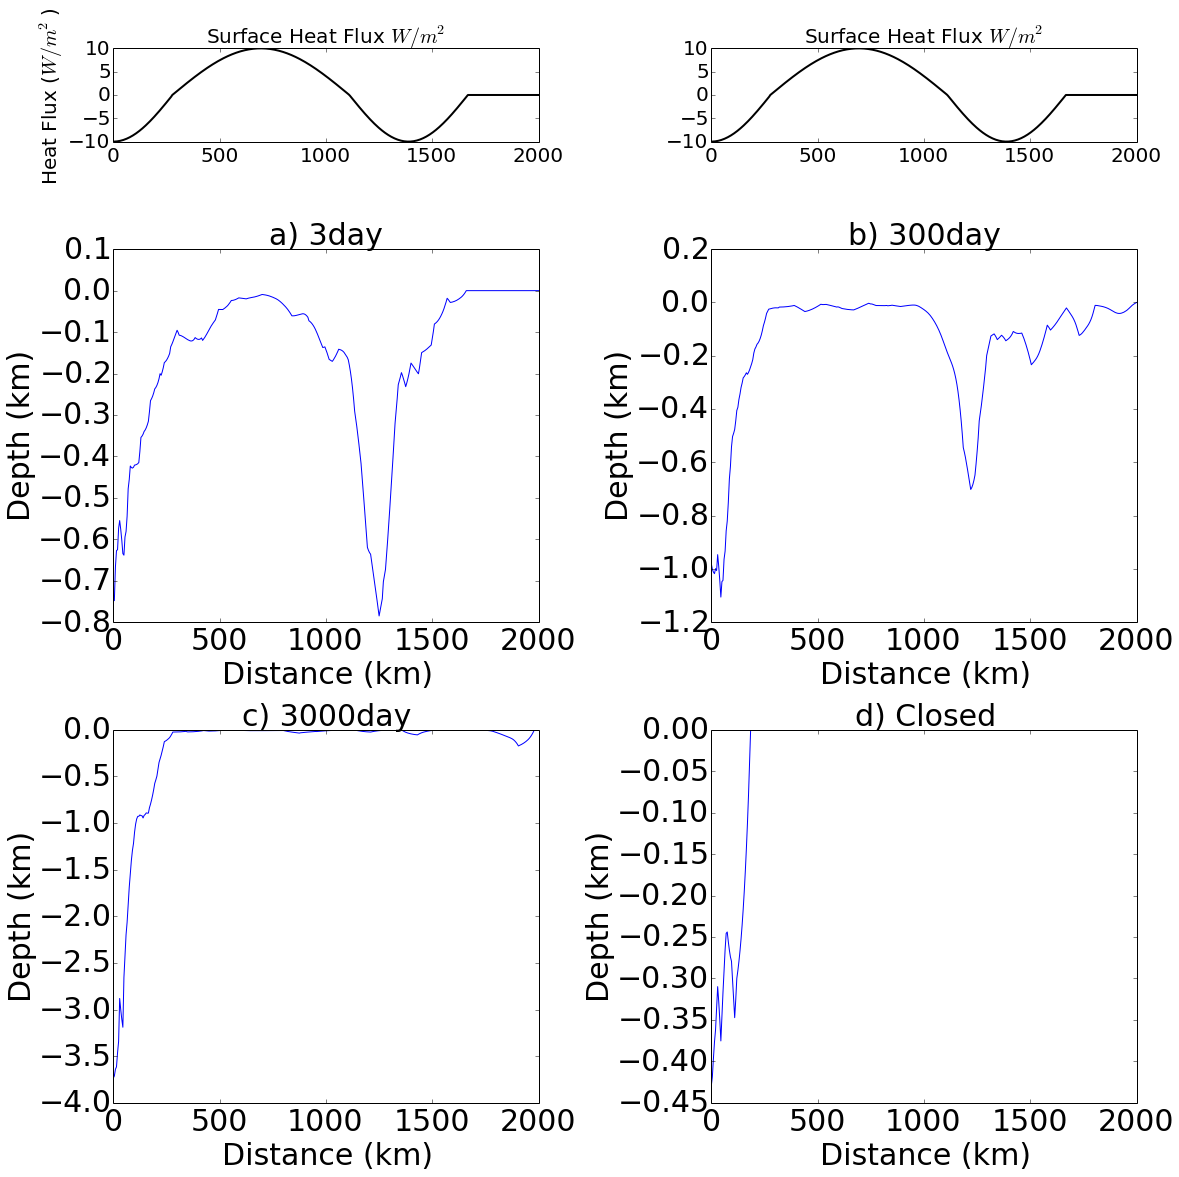

In [81]:
fig = plt.figure(figsize=(16.5, 16.5))
# Plot Heat Flux on top
if Qplot == 'Y':
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
    ax = plt.subplot(gs[0])
    ax.plot(Yc/1000,-Q, color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax = plt.subplot(gs[1])
    ax.plot(Yc/1000,-Q,  color='k', linewidth=2)
    ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
# Create Panels
Psi_levs = np.arange(-0., 1.1, .1)
Psi_ticks =np.arange(-0., 1.1, .2)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/PSI.nc'
    file2read = netCDF4.Dataset(fname, 'r')
    lvrho = file2read.variables["LaVH1TH"][:]
    th = file2read.variables["LaHs1TH"][:].mean(axis=3).mean(axis=0)
    Va = file2read.variables["LaVa1TH"][:].mean(axis=3).mean(axis=0)
    P = file2read.variables["LaPs1TH"][:].mean(axis=3).mean(axis=0)
    dx = Y[1]-Y[0]  # Find Resolution
    VT = np.sum(lvrho*dx, axis=3)  # integrate Vdx along x
    VTfdz = np.cumsum(VT[:, ::-1, :], axis=1)  # sum up the water column
    VTfdz = numba_regridy(VTfdz)
    # Time average and put into Sv and put back in right order
    psi = np.mean(VTfdz[:, ::-1, :], axis=0)/10**6
    psiz = get_psi_iso_z(psi, th[0:-1,:],Z)
    Paz =  get_psi_iso_z(P, th[:,:],Z)
    Depths =  th
    P[P>=0.95]=0
    Depths[P==0]=0
    Dlayer = np.sum(Depths,axis=0)
    Rho = np.genfromtxt(x+'/'+str(tau[Runs[i]])+'daynokpp/Temp', delimiter=',')
    Tlayers = Rho[1:-1]
    Rho_matrix = np.apply_along_axis(np.multiply,0,ones_like(Va),Tlayers)
    Vaz =  get_psi_iso_z(Va*Rho_matrix, th[:,:],Z)

 
    A = x+'/'+str(tau[Runs[i]])+'daynokpp/TAV.nc'
    file2 = netCDF4.Dataset(A, 'r')
    Temp = file2.variables['THETA'][:]
    Tav = np.mean(Temp, axis=0)
    # Mean Overturning for Eddy Streamfuction
    V = file2.variables['VVEL'][:]
    Tavlat = np.mean(Tav, axis=2)
    Vtave = np.mean(V, axis=0)
    Vtave[Vtave == 0] = np.nan
    Vzone = np.nansum(Vtave*dx, axis=2)
    dz = Zp[0:len(Zp)-1]-Zp[1:len(Zp)]
    # No more super slow forloop!
    psi_m = np.apply_along_axis(np.multiply, 0, Vzone, dz)
    psi_m = np.cumsum(-psi_m[::-1, :], axis=0)
    npad = ((0, 1), (0, 0))
    psi_m = np.pad(psi_m, pad_width=npad, mode='constant', constant_values=0)
    # Eddy
    Psied = psiz - numba_regridz(psi_m)/10**6
    
    # PLOT PANNELS
    EddyHeatFlux =  numba_regridy(Vaz[:,:])-numba_regridy(Vtave.mean(axis=2))*Tavlat*Zmatrix[:,0:400]
    EddyHeatFlux[-10::] = 0
    if Full != 'Y' and Qplot == 'Y':
        ax = plt.subplot(gs[2+i])
    elif Full != 'Y' and Qplot == 'N':
        ax = fig.add_subplot(2, 2, i)
    else:
        ax = fig.add_subplot(3, 3, i)
    Q2_levs = (np.arange(-1,8,1))
    #p = ax.contour(Y/1000, Tlayers,
    #       P,Psi_levs)
    #q = ax.contour(Yc/1000, Z/1000, Tavlat, Q2_levs, colors='k', linewidths=2)
    #q.levels = [nf(val) for val in q.levels]
    #plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    p = plt.plot(Y/1000,SG.savitzky_golay(-Dlayer,15,1))
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
#cax = fig.add_axes([1, 0.1, 0.03, 0.8])
#cbar = fig.colorbar(p, cax=cax, )
#cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
#cbar.ax.tick_params(labelsize=30)

In [94]:
%%bash
which ipython

/noc/users/hb1g13/.conda/envs/my_anaconda/bin/ipython
